# Results + Plots of Model Metrics

In [ ]:
try:
    from google.colab import drive

    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False

if IN_COLAB:
    print("We're running Colab")

We're running Colab


# Mount the Google Drive (if we're in Colab), switch current directory to a directory on the Google Drive
- we will (optionally) create the specified directory on the Google Drive if it doesn't exist

- navigate to our Harvard Capstone shared folder -> right-click -> organize -> add shortcut -> all locations -> add "My Drive"

In [ ]:
if IN_COLAB:
    # Mount the Google Drive at mount
    mount = "/content/gdrive"
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Switch to the directory on the Google Drive that you want to use
    import os

    drive_root = mount + "/My Drive/Harvard Capstone/Modeling/UNet"

    # Create drive_root if it doesn't exist
    # create_drive_root = True
    # if create_drive_root:
    #  print("\nColab: making sure ", drive_root, " exists.")
    #  os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root

Colab: mounting Google drive on  /content/gdrive
Mounted at /content/gdrive

Colab: Changing directory to  /content/gdrive/My Drive/Harvard Capstone/Modeling/UNet
/content/gdrive/.shortcut-targets-by-id/1eW3hLH0IEClxPvf9Y2NP-NAtoaEftFcx/UNet


In [ ]:
# Verify we're in the correct working directory
%pwd

'/content/gdrive/.shortcut-targets-by-id/1eW3hLH0IEClxPvf9Y2NP-NAtoaEftFcx/UNet'

## Verify that imports (of modules on the Google Drive) work

In [ ]:
import glob, json, os
import datetime as dt
import datetime
from IPython.display import HTML
from pathlib import Path
import json
from functools import partial
import gc

import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy import ndimage
from scipy.ndimage import sobel, binary_erosion, label
import skimage
import numba
import scipy
import scipy.spatial
import sklearn

# Set configuration constants

In [ ]:
data_root = "masked_ims_netcdf_1km_cropped_2_000km_window_74lat_-170lon/"
lstm_data_root = "lstm_data"
if not IN_COLAB:
    data_root = os.path.join("..", "data", data_root)
    # tf.config.set_visible_devices([], "GPU")
WINDOW_SIZE = 2000  # km

In [ ]:
batch_size = 1
test_batch_size = 1

# Load Data Functions

In [ ]:
# Define a function to load a single .nc file for a given year and day
def load_nc_file(year, day) -> xr.Dataset:
    """Loads the cropped, grid-corrected netcdf files on the Beaufort Sea with 74,0lat_-170,0lon"""
    # Generate the file path based on the year and day
    file_path = os.path.join(
        data_root,
        str(year),
        f"ims{year}{day:03d}_1km_v1.3_grid{WINDOW_SIZE}_74,0lat_-170,0lon.nc",
    )

    # Load the .nc file using xarray
    with xr.open_dataset(file_path) as dataset:
        return dataset

In [ ]:
def load_sie_data(year, day) -> np.array:
    """Returns a 2D numpy array copy of the IMS surface values"""
    return load_nc_file(year, day).IMS_Surface_Values[0].values.copy()

In [ ]:
def load_pred_lstm(year, day, month):
    file_path = os.path.join(
        lstm_data_root,
        f"2023_npy_{month}_predicted",
        f"ims{year}{day:03d}_1km_v1_grid1000.npy",
    )
    return np.load(file_path)


def load_actual_lstm(year, day, month):
    file_path = os.path.join(
        lstm_data_root,
        f"2023_npy_{month}_actual",
        f"ims{year}{day:03d}_1km_v1_grid1000.npy",
    )
    return np.load(file_path)

In [ ]:
def load_binary_actual_sie_data(year, day, month) -> np.array:
    """Returns a 2D numpy array copy of the IMS surface values"""
    sie = load_actual_lstm(year, day, month)
    binary_sie = sie.copy()

    # Sea and Lake Ice is treated as 1
    binary_sie[sie == 3] = 1

    binary_sie[sie != 3] = 0
    binary_sie[sie == 2] = 0
    binary_sie[sie == 4] = 0
    return binary_sie

In [ ]:
def load_masked_binary_sie_data(year, day) -> np.array:
    sie = load_sie_data(year, day)
    binary_sie = sie.copy()
    # Send land to the open water class so we have 0 (not sea ice) and 1 (sea ice).
    binary_sie[sie == 2] = 0

    return binary_sie

### Provide a path to a folder with the .npy predictions

    # no lake mask, 3 day lookback, small model
    final_model = "./Saved Models/sobel_unet_with_2d_output_model.h5py"

    # lake mask, seven epochs, 3 day lookback, big model
    model_path = "./model_checkpoints/jbacon/unet_sobel_with_sie_02:49PM_April_22_2024_2000km_3dayhistory/cp-0007.ckpt"

    # lake mask, 9 epochs, 4 day lookback, small model
    small_model_path = "./model_checkpoints/jbacon/unet_sobel_with_sie_10:04PM_April_21_2024_2000km_4dayhistory/cp-0009.ckpt"

    sobel_checkpoint_dir = pathlib.Path(model_path).parent

    # big unet 3 day lookback masked

        model_path = "./model_checkpoints/jbacon/unet_04:00AM_April_22_2024_2000km/cp-0009.ckpt"


In [ ]:
# 4 day lookback
small_unet_prediction_directory = (
    "./model_checkpoints/jbacon/unet_11:36PM_April_19_2024_2000km"
)

# small_big_epochs_unmasked_sobel_prediction_directory = "./Saved Models"
# small_unmasked_3_day_sobel = "./model_checkpoints/jbacon/unet_sobel_with_sie_10:10PM_March_30_2024_2000km"
small_sobel_masked_4_day = "./model_checkpoints/jbacon/unet_sobel_with_sie_10:04PM_April_21_2024_2000km_4dayhistory"

big_unet_path = "./model_checkpoints/jbacon/unet_04:00AM_April_22_2024_2000km"

big_sobel_path = "./model_checkpoints/jbacon/unet_sobel_with_sie_02:49PM_April_22_2024_2000km_3dayhistory"

lstm_prediction_directory = "./lstm_data"

# Compare Model Performances

In [ ]:
dataset = "validation"
unet_model_results = os.path.join(
    ".", Path(big_unet_path), f"model_{dataset}_all_metrics_fixed_accuracy_results.json"
)
small_unet_model_results = os.path.join(
    ".",
    Path(small_unet_prediction_directory),
    f"model_{dataset}_all_metrics_fixed_accuracy_results.json",
)

sobel_model_results = os.path.join(
    ".",
    Path(big_sobel_path),
    f"model_{dataset}_all_metrics_fixed_accuracy_results.json",
)
small_sobel_model_results = os.path.join(
    ".",
    Path(small_sobel_masked_4_day),
    f"model_{dataset}_all_metrics_fixed_accuracy_results.json",
)

lstm_model_results = os.path.join(
    ".",
    Path(lstm_prediction_directory),
    f"model_validation_threshold0_5_fixed_lookback_results_results.json",
)
lstm_smaller_thresh_model_results = os.path.join(
    ".",
    Path(lstm_prediction_directory),
    "model_validation_threshold0_2_fixed_lookback_results_results.json",
)

# Add another model results dir to this list
results_filepaths = {
    "unet": unet_model_results,
    "small_unet": small_unet_model_results,
    "sobel": sobel_model_results,
    "small_sobel": small_sobel_model_results,
    "lstm_0.5thres": lstm_model_results,
    "lstm_0.2thres": lstm_smaller_thresh_model_results,
}

In [ ]:
# dataset = "validation"
# unet_model_results = os.path.join(".", Path(big_unet_path), "model_validation_fixed_lookback_2023accuracy_ratio_results.json")
# small_unet_model_results = os.path.join(".", Path(small_unet_prediction_directory), "model_validation_fixed_lookback_2023accuracy_ratio_results.json")

# sobel_model_results = os.path.join(".", Path(big_sobel_path), "model_test_fixed_lookback_2023accuracy_ratio_results.json")
# small_sobel_model_results =  os.path.join(".", Path(small_sobel_masked_4_day), "model_test_fixed_lookback_2023accuracy_ratio_results.json")

# lstm_model_results = os.path.join(".",  Path(lstm_prediction_directory), "model_validation_threshold0_5_accuracy_ratio_results.json")
# lstm_smaller_thresh_model_results = os.path.join(".",  Path(lstm_prediction_directory), "model_validation_threshold0_2_accuracy_ratio_results.json")

# # Add another model results dir to this list
# results_filepaths = {"unet": unet_model_results, "small_unet": small_unet_model_results,
#                      "sobel": sobel_model_results, #"small_sobel": small_sobel_model_results,
#                      "lstm_0.5thres": lstm_model_results, "lstm_0.2thres": lstm_smaller_thresh_model_results}

In [ ]:
def read_json_results(file_path):
    """Read JSON data from a file."""
    with open(file_path, "r") as file:
        data = json.load(file)
    return data


def create_dataframe_from_json(file_dict):
    """Create a DataFrame from multiple JSON files."""
    data_frames = []
    suffixes = []
    for model, file in file_dict.items():
        data = read_json_results(file)
        df = pd.DataFrame.from_dict(data, orient="index")
        df["date"] = df.index
        data_frames.append(df)
        suffixes.append("_" + model)

    # Start with the first dataframe as the initial merged dataframe
    merged_df = data_frames[0].copy()

    # Iterate over the remaining dataframes and suffixes
    for df, suffix in zip(
        data_frames[1:], suffixes[1:]
    ):  # start from second item as first is used as base
        merged_df = pd.merge(
            merged_df,
            df,
            how="outer",
            on="date",
            suffixes=(suffixes[suffixes.index(suffix) - 1], suffix),
        )

    merged_df.set_index("date", inplace=True)

    return merged_df

In [ ]:
def plot_line_results(df):
    """Plot the results for comparison."""
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    # Average plot
    for label, group_df in df.groupby("model"):
        group_df.plot(
            x="date",
            y=f"avg_{label}",
            ax=axes[0],
            label=label,
            kind="scatter",
            alpha=0.6,
            marker="o",
        )
    axes[0].set_title("Average (avg) Comparison")
    axes[0].set_ylabel("Average Value")
    axes[0].set_xlabel("Date (Year_Day)")
    axes[0].grid(True)

    # RMS plot
    for label, group_df in df.groupby("model"):
        group_df.plot(
            x="date",
            y=f"rms_{label}",
            ax=axes[1],
            label=label,
            kind="scatter",
            alpha=0.6,
            marker="o",
        )
    axes[1].set_title("Root Mean Square (rms) Comparison")
    axes[1].set_ylabel("RMS Value")
    axes[1].set_xlabel("Date (Year_Day)")
    axes[1].grid(True)

    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_bar_results(df, labels: list = None):
    """Plot the results for comparison including a 30-day moving average bar chart with improved x-axis labels and distinct colors."""
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    colors = [
        "blue",
        "orange",
        "green",
        "red",
    ]  # Extend this list with more colors if you have more models

    # Bar plots for 30-day moving average of 'avg' and 'rms'
    for index, (label, group_df) in enumerate(df.groupby("model")):
        # group_df.set_index('date', inplace=True)
        group_df.sort_index(inplace=True)
        rolling_avg = group_df[f"avg_{label}"].rolling(window=30).mean()
        rolling_rms = group_df[f"rms_{label}"].rolling(window=30).mean()
        rolling_avg.plot(
            kind="bar", ax=axes[0], color=colors[index], label=label, alpha=0.6
        )
        rolling_rms.plot(
            kind="bar", ax=axes[1], color=colors[index], label=label, alpha=0.6
        )

    axes[0].set_title("30-Day Moving Average of Average")
    axes[0].set_ylabel("Average Value (30-Day Avg)")
    axes[0].set_xlabel("Date (Year_Day)")
    axes[1].set_title("30-Day Moving Average of RMS")
    axes[1].set_ylabel("RMS Value (30-Day Avg)")
    axes[1].set_xlabel("Date (Year_Day)")

    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_metrics(dataframe, models, metrics, title_extras):
    # Iterate over each unique metric
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        # Iterate over each model for the current metric
        for model in models:
            series = dataframe[f"{metric}_{model}"]
            series.plot(
                label=f"{model} ({metric})", alpha=0.5
            )  # linestyle='-', marker='o', markersize=3
        plt.title(f"{title_extras[metric]} Comparison Across Models")
        plt.xlabel("Date", fontsize=12)
        plt.ylabel(metric.capitalize(), fontsize=12)
        plt.legend(title="Model")
        plt.grid(True)
        plt.gca().spines[["top", "right"]].set_visible(False)
        plt.show()

In [ ]:
from datetime import datetime


def convert_year_day_to_datetime(year_day):
    year = int(str(year_day).split("_")[0])  # Extract the year part
    day_of_year = int(str(year_day).split("_")[1])  # Extract the day of the year part
    date = datetime(year, 1, 1) + pd.Timedelta(days=day_of_year - 1)  # Create the date
    return date


def datetime_to_yearday(date):
    return f"{date.year}_{date.timetuple().tm_yday:03d}"

In [ ]:
def plot_average_metrics_grouped_bar(dataframe, models, metrics, title_extras):
    # Define the number of groups and the width of each bar
    n_groups = len(models)
    bar_width = 0.35
    index = np.arange(n_groups)
    dataframe = dataframe.copy()
    dataframe.index = pd.to_datetime(dataframe.index.map(convert_year_day_to_datetime))
    dataframe.sort_index(inplace=True)
    dataframe.index = dataframe.index.map(datetime_to_yearday)

    # Iterate over each unique metric
    for metric in metrics:
        plt.figure(figsize=(12, 12))

        averages = []
        for model in models:
            column_name = f"{metric}_{model}"
            if column_name in dataframe.columns:
                model_avg = (
                    dataframe[column_name]
                    .rolling(window=30, min_periods=25, step=30)
                    .mean()
                )
                averages.append(model_avg)
            else:
                averages.append(
                    0
                )  # Append zero if the metric-model combination doesn't exist

        ax = pd.concat(
            [model_avg.rename(model) for model_avg, model in zip(averages, models)],
            axis=1,
        ).plot.bar()

        # # Create a bar plot for each model under the current metric
        # bars = plt.bar(index, averages, bar_width, alpha=0.75, label=metric)

        plt.xlabel("Model", fontsize=12)
        plt.ylabel(f"30 Day Average Value of {metric}", fontsize=12)
        plt.title(title_extras[metric])
        # plt.xticks(index[::30], [f"{model}" for model in models], rotation=45)
        plt.legend(title="Model")

        # # Add value labels on top of each bar
        # print(ax.patches)
        # for p in ax.patches:
        #     ax.annotate(str(np.round(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

        plt.grid(True, axis="y")
        plt.gca().spines["top"].set_visible(False)
        plt.gca().spines["right"].set_visible(False)
        plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
        plt.show()

In [ ]:
df = create_dataframe_from_json(results_filepaths)

In [ ]:
df

,avg_unet,rms_unet,total_abs_unet,jaccard_unet,ssim_unet,accuracy_unet,edge_ratio_unet,avg_small_unet,rms_small_unet,total_abs_small_unet,...,ssim_lstm_0.5thres,accuracy_lstm_0.5thres,edge_ratio_lstm_0.5thres,avg_lstm_0.2thres,rms_lstm_0.2thres,total_abs_lstm_0.2thres,jaccard_lstm_0.2thres,ssim_lstm_0.2thres,accuracy_lstm_0.2thres,edge_ratio_lstm_0.2thres
date,,,,,,,,,,,,,,,,,,,,,
2023_100,0.028932,2.300332,1510.83811,0.999995,0.999964,0.999996,1.000728,0.030073,2.301988,1570.423896,...,0.999928,0.999999,0.999251,0.201543,8.847688,12918.570556,0.999998,0.999928,0.999999,0.999251
2023_101,0.028932,2.300332,1510.83811,0.999995,0.999964,0.999996,1.000728,0.030073,2.301988,1570.423896,...,0.999928,0.999999,0.999251,0.201543,8.847688,12918.570556,0.999998,0.999928,0.999999,0.999251
2023_102,0.028932,2.300332,1510.83811,0.999995,0.999964,0.999996,1.000728,0.030073,2.301988,1570.423896,...,0.999928,0.999999,0.999251,0.201543,8.847688,12918.570556,0.999998,0.999928,0.999999,0.999251
2023_103,0.028932,2.300332,1510.83811,0.999995,0.999964,0.999996,1.000728,0.030073,2.301988,1570.423896,...,0.999928,0.999999,0.999251,0.201543,8.847688,12918.570556,0.999998,0.999928,0.999999,0.999251
2023_104,0.028932,2.300332,1510.83811,0.999995,0.999964,0.999996,1.000728,0.030073,2.301988,1570.423896,...,0.999928,0.999999,0.999251,0.201543,8.847688,12918.570556,0.999998,0.999928,0.999999,0.999251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023_87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.999928,0.999999,0.999251,0.201543,8.847688,12918.570556,0.999998,0.999928,0.999999,0.999251
2023_88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.999928,0.999999,0.999251,0.201543,8.847688,12918.570556,0.999998,0.999928,0.999999,0.999251
2023_89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.999928,0.999999,0.999251,0.201543,8.847688,12918.570556,0.999998,0.999928,0.999999,0.999251


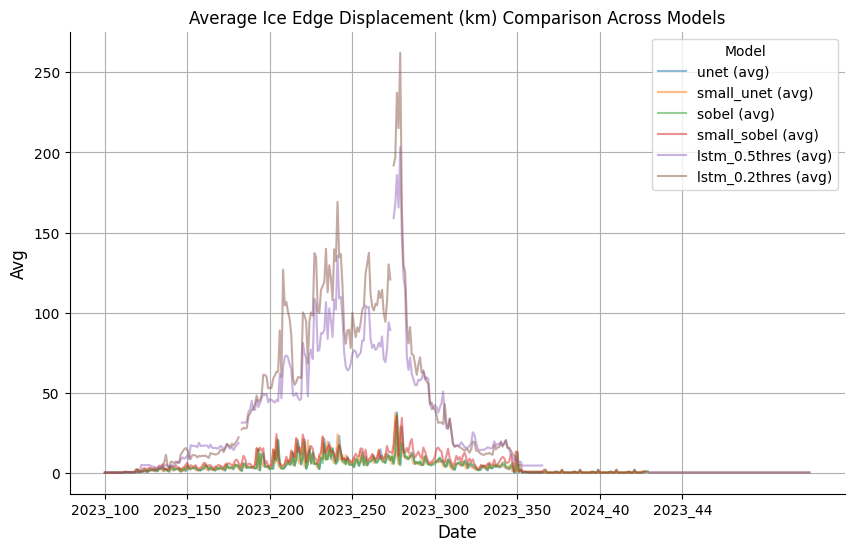

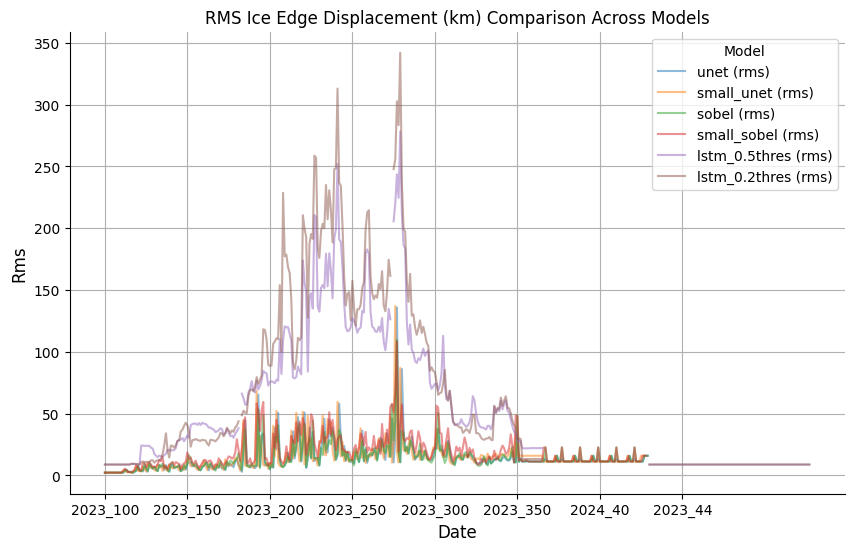

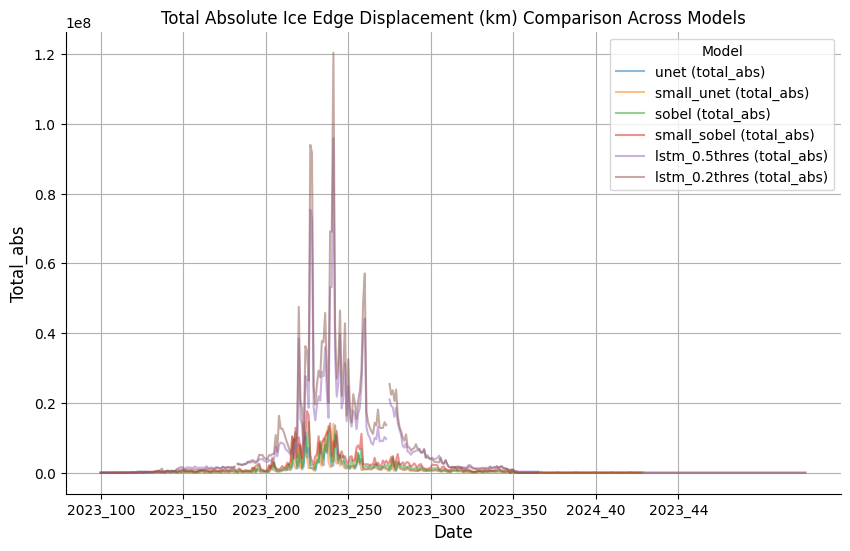

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

metrics = ["avg", "rms", "total_abs", "jaccard", "ssim", "accuracy", "edge_ratio"]
title_extras = dict(
    zip(
        metrics,
        [
            "Average Ice Edge Displacement (km)",
            "RMS Ice Edge Displacement (km)",
            "Total Absolute Ice Edge Displacement (km)",
            "Jaccard Score",
            "Structural Similarity Index Measure (SSIM)",
            "Accuracy Score",
            "Ice Edge Ratio: # of Model to # of True Edge Pixels",
        ],
    )
)
# models = [k for k in results_filepaths.keys() if k !='lstm_0.5thres' and k !="lstm_0.2thres"]
models = results_filepaths.keys()

plot_metrics(df, models, metrics, title_extras=title_extras)

In [ ]:
# Example usage
plot_average_metrics_grouped_bar(df, models, metrics, title_extras)

In [ ]:
def plot_average_metrics_bar(dataframe, models, metrics, title_extras):
    # Determine the subplot grid dimensions
    n_metrics = len(metrics)
    cols = 3  # Number of columns in subplot grid
    rows = (n_metrics + cols - 1) // cols  # Calculate rows needed

    # Create a figure with multiple subplots
    fig, axs = plt.subplots(
        nrows=rows, ncols=cols, figsize=(cols * 5, rows * 5), constrained_layout=True
    )
    axs = axs.ravel()  # Flatten the array of axes if it's multidimensional

    for i, metric in enumerate(metrics):
        # Prepare data for bar plot: calculate 30-day averages for each model
        averages = []
        model_labels = []
        for model in models:
            column_name = f"{metric}_{model}"
            if column_name in dataframe.columns:
                # Calculate the 30-day rolling average and then take the mean of this period
                model_avg = dataframe[column_name].mean()
                averages.append(model_avg)
                model_labels.append(model)

        # Plotting the bar graph in its respective subplot
        colors = [
            "#1f77b4",
            "#ff7f0e",
            "#2ca02c",
            "#d62728",
            "#9467bd",
            "#8c564b",
            "#e377c2",
        ]
        bars = axs[i].bar(
            model_labels, averages, color=colors
        )  # Random color for each bar

        # Add value labels on top of each bar
        for bar in bars:
            yval = np.round(bar.get_height(), 2)
            axs[i].text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                round(yval, 2),
                ha="center",
                va="bottom",
                fontsize=10,
            )  # Align text

        axs[i].set_title(f"{title_extras[metric]}", fontsize=16)
        axs[i].set_ylabel(f"Average {metric.capitalize()}", fontsize=16)
        axs[i].set_xticklabels(model_labels, rotation=45, fontsize=12)
        axs[i].grid(True, axis="y")
        axs[i].spines["top"].set_visible(False)
        axs[i].spines["right"].set_visible(False)

    # Hide unused subplots if there are any
    for j in range(i + 1, rows * cols):
        axs[j].axis("off")

    plt.show()

<ipython-input-55-b365e60af2d9>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(model_labels, rotation=45, fontsize=12)


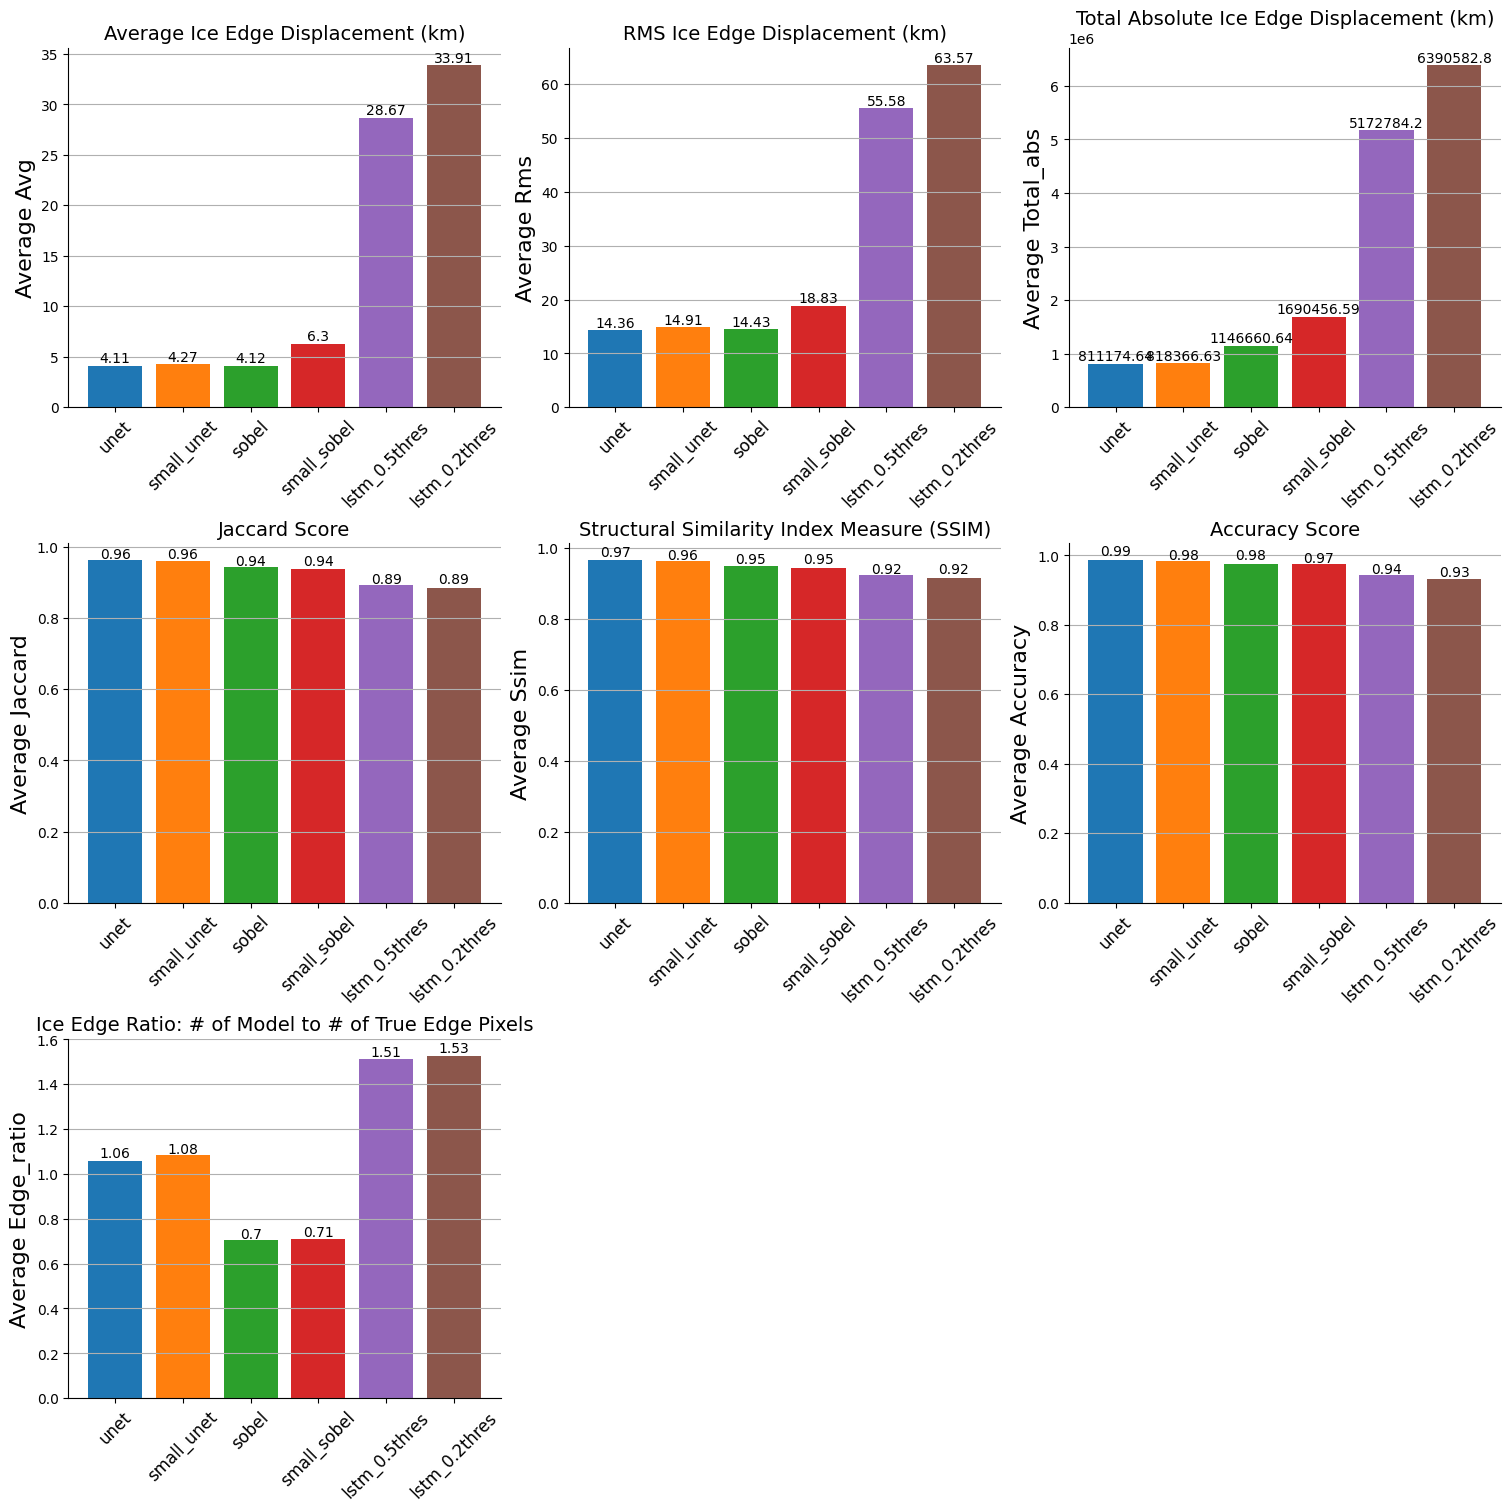

In [ ]:
plot_average_metrics_bar(df, models, metrics, title_extras=title_extras)

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


def plot_average_metrics_bar(dataframe, models, metrics, title_extras):
    # Iterate over each unique metric
    for metric in metrics:
        # Prepare data for bar plot: calculate 30-day averages for each model
        averages = []
        model_labels = []
        for model in models:
            column_name = f"{metric}_{model}"
            if column_name in dataframe.columns:
                # Calculate the 30-day rolling average and then take the mean of this period
                model_avg = (
                    dataframe[column_name]
                    .rolling(window=30, min_periods=1)
                    .mean()
                    .mean()
                )
                averages.append(model_avg)
                model_labels.append(f"{model} ({metric})")

        # Plotting the bar graph
        plt.figure(figsize=(10, 6))
        bars = plt.bar(
            model_labels,
            averages,
            color=np.random.rand(
                3,
            ),
        )  # Random color for each bar
        # Add value labels on top of each bar
        for bar in bars:
            yval = np.round(bar.get_height(), 2)
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                round(yval, 2),
                va="bottom",
                fontsize=12,
            )  # va: vertical alignment

        plt.title(f"{title_extras[metric]} Comparison Across Models", fontsize=14)
        plt.ylabel(f"Average {metric.capitalize()}", fontsize=16)
        plt.xticks(
            rotation=45, fontsize=12
        )  # Rotate model labels for better readability
        plt.grid(True, axis="y")  # Only horizontal grid lines
        plt.gca().spines["top"].set_visible(False)
        plt.gca().spines["right"].set_visible(False)
        plt.show()

In [ ]:
df.mean()

avg_unet                    4.108498e+00
rms_unet                    1.435610e+01
total_abs_unet              8.111746e+05
jaccard_unet                9.621698e-01
ssim_unet                   9.655612e-01
accuracy_unet               9.853478e-01
edge_ratio_unet             1.057578e+00
avg_small_unet              4.268919e+00
rms_small_unet              1.491135e+01
total_abs_small_unet        8.183666e+05
jaccard_small_unet          9.615792e-01
ssim_small_unet             9.640630e-01
accuracy_small_unet         9.848969e-01
edge_ratio_small_unet       1.083214e+00
avg_sobel                   4.121984e+00
rms_sobel                   1.443280e+01
total_abs_sobel             1.146661e+06
jaccard_sobel               9.424805e-01
ssim_sobel                  9.488966e-01
accuracy_sobel              9.763746e-01
edge_ratio_sobel            7.049373e-01
avg_small_sobel             6.302228e+00
rms_small_sobel             1.882602e+01
total_abs_small_sobel       1.690457e+06
jaccard_small_so

In [ ]:
df.columns

Index(['avg_unet', 'rms_unet', 'total_abs_unet', 'jaccard_unet', 'ssim_unet',
       'accuracy_unet', 'edge_ratio_unet', 'avg_small_unet', 'rms_small_unet',
       'total_abs_small_unet', 'jaccard_small_unet', 'ssim_small_unet',
       'accuracy_small_unet', 'edge_ratio_small_unet', 'avg_sobel',
       'rms_sobel', 'total_abs_sobel', 'jaccard_sobel', 'ssim_sobel',
       'accuracy_sobel', 'edge_ratio_sobel', 'avg_small_sobel',
       'rms_small_sobel', 'total_abs_small_sobel', 'jaccard_small_sobel',
       'ssim_small_sobel', 'accuracy_small_sobel', 'edge_ratio_small_sobel',
       'avg_lstm_0.5thres', 'rms_lstm_0.5thres', 'total_abs_lstm_0.5thres',
       'jaccard_lstm_0.5thres', 'ssim_lstm_0.5thres', 'accuracy_lstm_0.5thres',
       'edge_ratio_lstm_0.5thres', 'avg_lstm_0.2thres', 'rms_lstm_0.2thres',
       'total_abs_lstm_0.2thres', 'jaccard_lstm_0.2thres',
       'ssim_lstm_0.2thres', 'accuracy_lstm_0.2thres',
       'edge_ratio_lstm_0.2thres'],
      dtype='object')

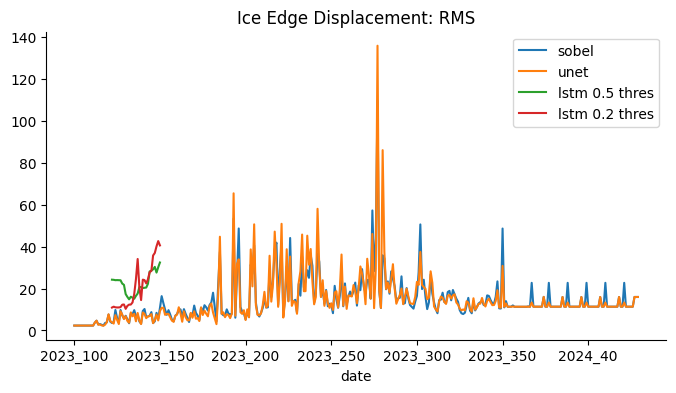

In [ ]:
# @title rms_unet

from matplotlib import pyplot as plt

df["rms_sobel"].plot(kind="line", label="sobel")
df["rms_unet"].plot(
    kind="line", label="unet", figsize=(8, 4), title="Ice Edge Displacement: RMS"
)
df["rms_lstm"].plot(kind="line", label="lstm 0.5 thres", figsize=(8, 4))
df["rms_lstm_thres"].plot(kind="line", label="lstm 0.2 thres", figsize=(8, 4))
plt.legend()
plt.gca().spines[["top", "right"]].set_visible(False)

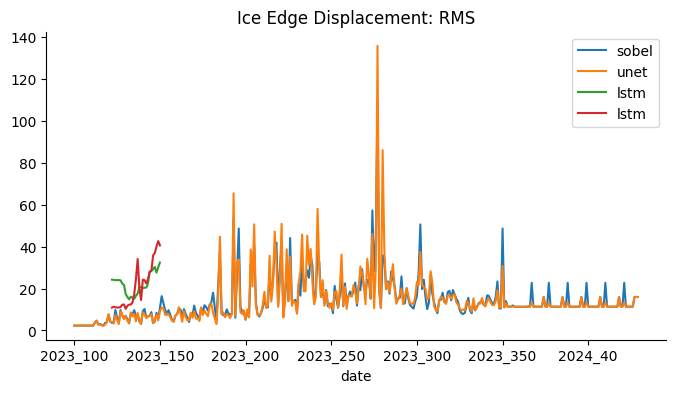

In [ ]:
from matplotlib import pyplot as plt

df["rms_sobel"].plot(kind="line", label="sobel")
df["rms_unet"].plot(
    kind="line", label="unet", figsize=(8, 4), title="Ice Edge Displacement: RMS"
)
df["rms_lstm"].plot(kind="line", label="lstm", figsize=(8, 4))
df["rms_lstm_thres"].plot(kind="line", label="lstm", figsize=(8, 4))
plt.legend()
plt.gca().spines[["top", "right"]].set_visible(False)

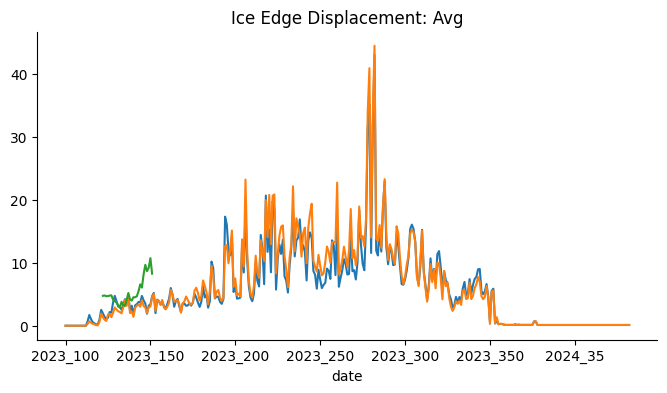

In [ ]:
# @title rms_unet

from matplotlib import pyplot as plt

df["avg_sobel"].plot(kind="line")
df["avg_unet"].plot(kind="line", figsize=(8, 4), title="Ice Edge Displacement: Avg")
df["avg_lstm"].plot(kind="line", figsize=(8, 4))

plt.gca().spines[["top", "right"]].set_visible(False)

In [ ]:
print("median diff", np.median((df["rms_sobel"] - df["rms_unet"]).values))
print("mean diff", np.mean((df["rms_sobel"] - df["rms_unet"]).values))

median diff -0.0012221735995794347
mean diff 0.07669589378972863


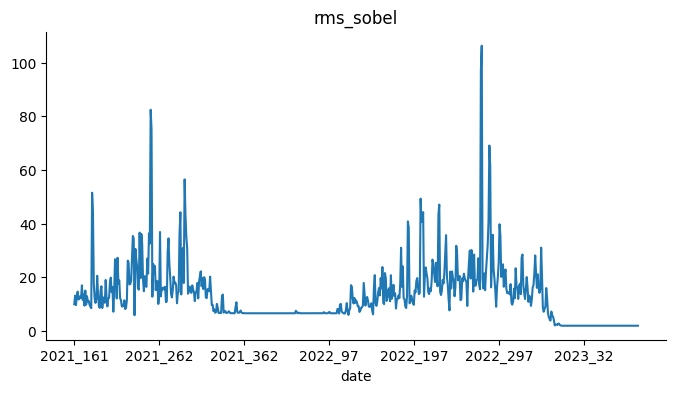

In [ ]:
# @title rms_sobel

from matplotlib import pyplot as plt

df["rms_sobel"].plot(kind="line", figsize=(8, 4), title="rms_sobel")
plt.gca().spines[["top", "right"]].set_visible(False)

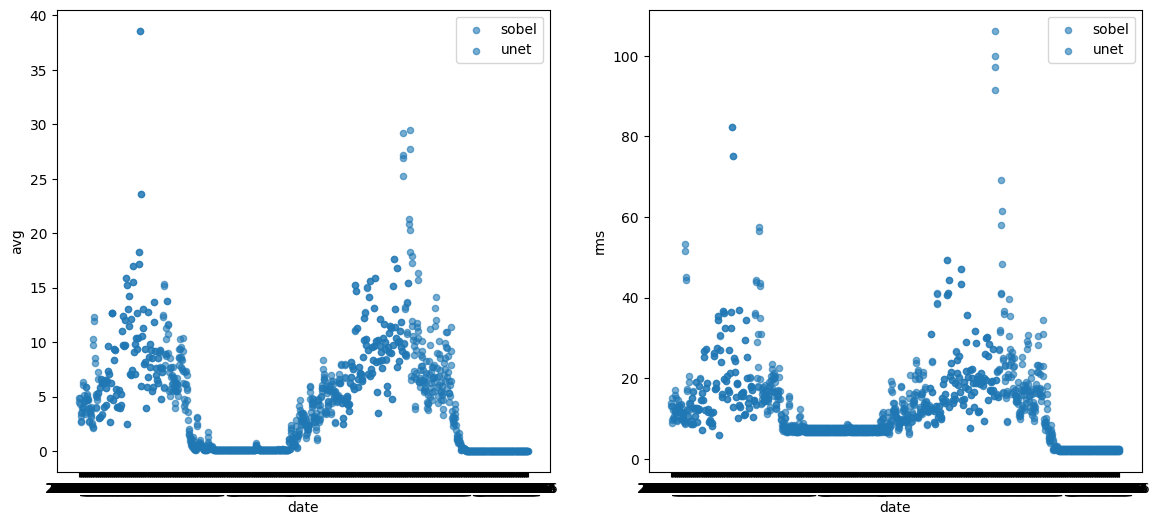

In [ ]:
plot_line_results(df)

In [ ]:
# def plot_grouped_bar_chart(ax, data, column, title, ylabel, x_label_skip=5):
#     """Plot a grouped bar chart for the given data."""
#     # Set positions for the groups
#     positions = range(len(data.index))

#     # Plot bars for each model next to each other
#     width = 0.35  # the width of the bars
#     model_names = data['model'].unique()
#     n_models = len(model_names)
#     for i, model in enumerate(model_names):
#         model_data = data[data['model'] == model]
#         ax.bar([p + (i - n_models / 2) * width for p in positions], model_data[column],
#                width, label=model)

#     # Set chart title and labels
#     ax.set_title(title)
#     ax.set_ylabel(ylabel)
#     ax.set_xlabel('Date (Year_Day)')

#     # Display only every x_label_skip label to avoid clutter
#     ax.set_xticks(positions[::x_label_skip])
#     ax.set_xticklabels(data.index[::x_label_skip])

#     ax.legend()

# def plot_results(df):
#     """Plot the results for comparison including a 30-day moving average grouped bar chart."""
#     fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))

#     # Sort the DataFrame by date to ensure that plots are in the correct order
#     df['date'] = pd.to_datetime(df['date'], format='%Y_%j')
#     df.sort_values('date', inplace=True)

#     # Line plots for average and RMS
#     for label, group_df in df.groupby('model'):
#         axes[0, 0].plot(group_df['date'], group_df['avg'], label=label, alpha=0.6, marker='o')
#         axes[0, 1].plot(group_df['date'], group_df['rms'], label=label, alpha=0.6, marker='o')
#     axes[0, 0].set_title('Average (avg) Comparison')
#     axes[0, 0].set_ylabel('Average Value')
#     axes[0, 0].set_xlabel('Date (Year_Day)')
#     axes[0, 0].grid(True)

#     axes[0, 1].set_title('Root Mean Square (rms) Comparison')
#     axes[0, 1].set_ylabel('RMS Value')
#     axes[0, 1].set_xlabel('Date (Year_Day)')
#     axes[0, 1].grid(True)

#     # Grouped bar plots for 30-day moving average of 'avg' and 'rms'
#     df['rolling_avg'] = df.groupby('model')['avg'].transform(lambda x: x.rolling(window=30).mean())
#     df['rolling_rms'] = df.groupby('model')['rms'].transform(lambda x: x.rolling(window=30).mean())

#     plot_grouped_bar_chart(axes[1, 0], df, 'rolling_avg', '30-Day Moving Average of Average', 'Average Value (30-Day Avg)')
#     plot_grouped_bar_chart(axes[1, 1], df, 'rolling_rms', '30-Day Moving Average of RMS', 'RMS Value (30-Day Avg)')

#     plt.tight_layout()
#     plt.show()

In [ ]:
# def plot_results(df):
#     """Plot the results for comparison including a 30-day moving average bar chart."""
#     fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))

#     # Line plots for average and RMS
#     for label, group_df in df.groupby('model'):
#         group_df.plot(x='date', y='avg', ax=axes[0, 0], label=label, alpha=0.6, marker='o')
#         group_df.plot(x='date', y='rms', ax=axes[0, 1], label=label, alpha=0.6, marker='o')
#     axes[0, 0].set_title('Average (avg) Comparison')
#     axes[0, 0].set_ylabel('Average Value')
#     axes[0, 0].set_xlabel('Date (Year_Day)')
#     axes[0, 0].grid(True)

#     axes[0, 1].set_title('Root Mean Square (rms) Comparison')
#     axes[0, 1].set_ylabel('RMS Value')
#     axes[0, 1].set_xlabel('Date (Year_Day)')
#     axes[0, 1].grid(True)

#     # Bar plots for 30-day moving average of 'avg' and 'rms'
#     for label, group_df in df.groupby('model'):
#         group_df.set_index('date', inplace=True)
#         group_df.sort_index(inplace=True)
#         rolling_avg = group_df['avg'].rolling(window=30).mean()
#         rolling_rms = group_df['rms'].rolling(window=30).mean()
#         rolling_avg.plot(kind='bar', ax=axes[1, 0], label=label, alpha=0.6)
#         rolling_rms.plot(kind='bar', ax=axes[1, 1], label=label, alpha=0.6)

#     axes[1, 0].set_title('30-Day Moving Average of Average')
#     axes[1, 0].set_ylabel('Average Value (30-Day Avg)')
#     axes[1, 0].set_xlabel('Date (Year_Day)')
#     axes[1, 1].set_title('30-Day Moving Average of RMS')
#     axes[1, 1].set_ylabel('RMS Value (30-Day Avg)')
#     axes[1, 1].set_xlabel('Date (Year_Day)')

#     plt.legend()
#     plt.tight_layout()
#     plt.show()